In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from load_data import get_data
from graphs import *

## Few notes:
* **total_clearance_between_visit** - wzgledem poprzedniej wizyty
* **clearance_between_visit** - wzgledem poczatku
* we group to **nereast** time group 


#### To-dos:
* Sprawdz ilosc grup z peaku w gory!
* Sprawdzic linear fit i non-linear fit
* Sprawdz rozne 
* Sprawdz methodologie
* Sila statystyczna (p-value)
* Sprawdz rozne kwartaly
* Pogrobic linie

#### Few **old** notes:
* The table above should include all information You need
* `wizyta po ilu zabiegach` -> can have some skipped zabiegy & can start at other point than 0
* `czas` -> defined as czas between this and next visit



# Hard-Coded Area:

In [2]:
non_moved_df = get_data(format_type='all')
moved_df = get_data(format_type='moved_to_0')
non0s_df = get_data(format_type='all_without_0s')

print('looking at the moved data:')
moved_df.head(10)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
looking at the moved data:


,surname,time,summed_time,time_group,visit_number,total_clearance_between_visit,clearance_between_visit,------------,unmoved_visit_nr
0,1.Gasek,57,57,1,1,10.435940,10.435942,,1
1,1.Gasek,958,1015,4,2,14.814190,-1.710566,,2
2,1.Gasek,70,1085,1,3,10.424290,-2.877283,,3
3,1.Gasek,63,1148,1,4,24.239930,24.671780,,4
4,1.Gasek,238,1386,3,5,17.252580,-0.692089,,5
5,2. Kolodziejska,217,217,2,1,66.956580,66.956580,,1
6,2. Kolodziejska,42,259,0,2,41.810011,6.917547,,2
7,2. Kolodziejska,26,285,0,5,25.568145,-10.812106,,5
8,2. Kolodziejska,294,579,3,6,86.486312,22.210066,,6
9,4. Krzyszton,35,35,0,1,-46.287701,-17.363140,,3


In [3]:
# Print some overall info such as:
# nr of people w. different number of visits
# nr of people in different waiting buckets

# Main Graphs
### Srednia poprawa miedzy wizytami:

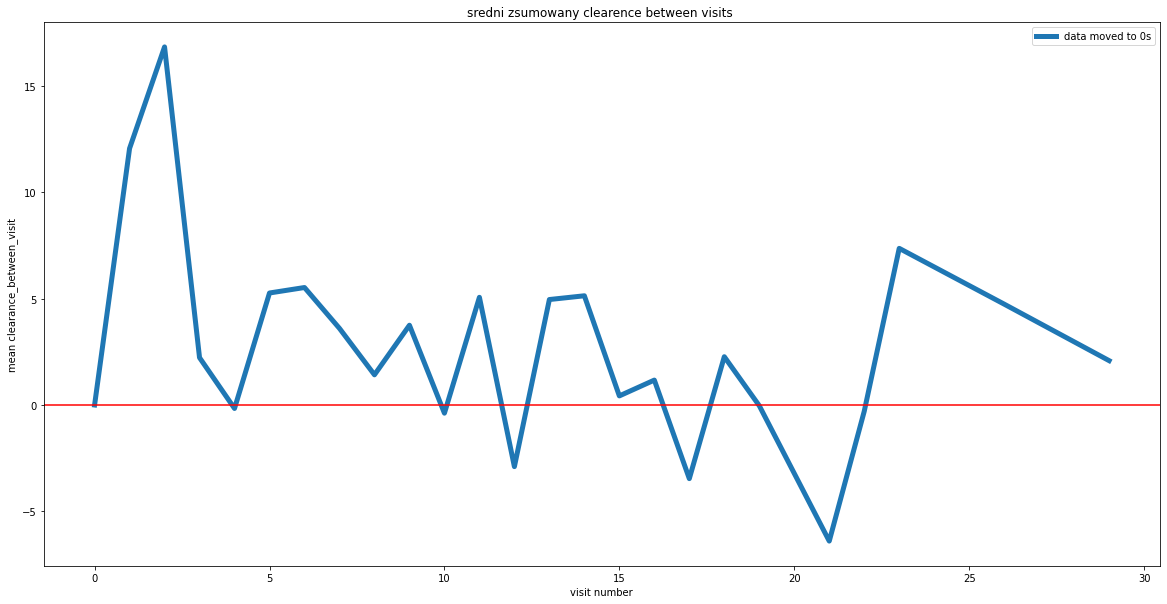

In [4]:
plt.figure(figsize=(20,10))
plt.title("srednia poprawa miedzy wizytami")
agg_column_graph(moved_df, label = 'data moved to 0s')
plt.legend()

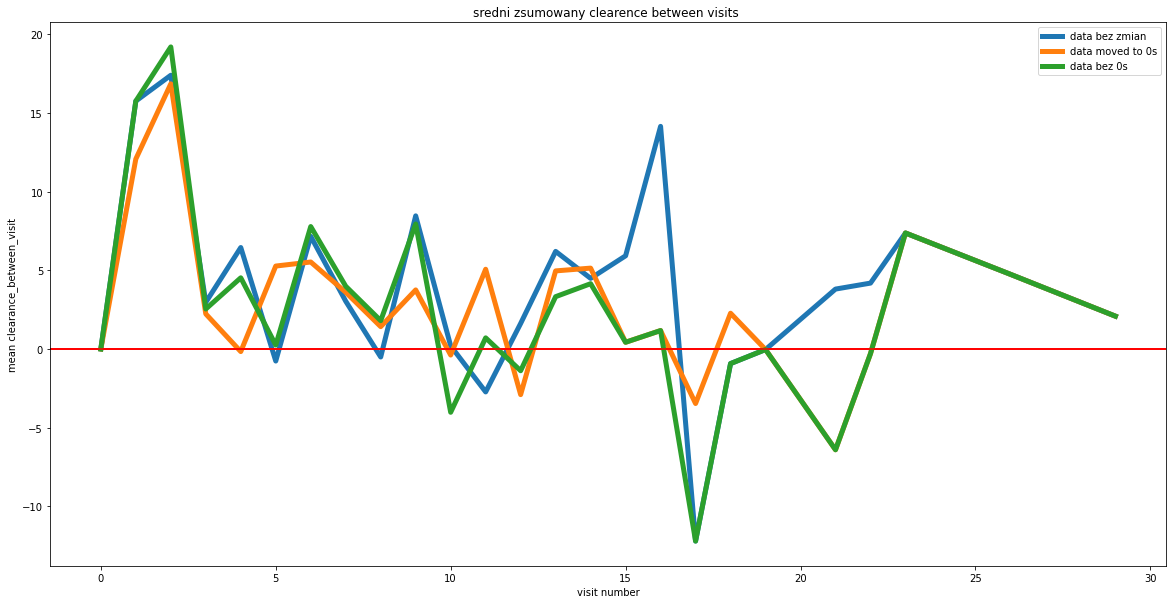

In [5]:
plt.figure(figsize=(20,10))
agg_column_graph(non_moved_df, label = 'data bez zmian')
agg_column_graph(moved_df, label = 'data moved to 0s')
agg_column_graph(non0s_df, label = 'data bez 0s')

## Time Group based avg graphs:
* Removed graphs for patients after 15th and 20th visit - since there is barely any data there

/Users/szczekulskij/side_projects/paper_publication/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_group'] = labeled_group


,time_group,patients_in_bucket wizyty 10 i dalsze,patients_in_bucket wizyty 5 i dalsze,patients_in_bucket wizyty 0 i dalsze
0,0,43,96,173
1,100,20,69,120
2,200,11,29,41


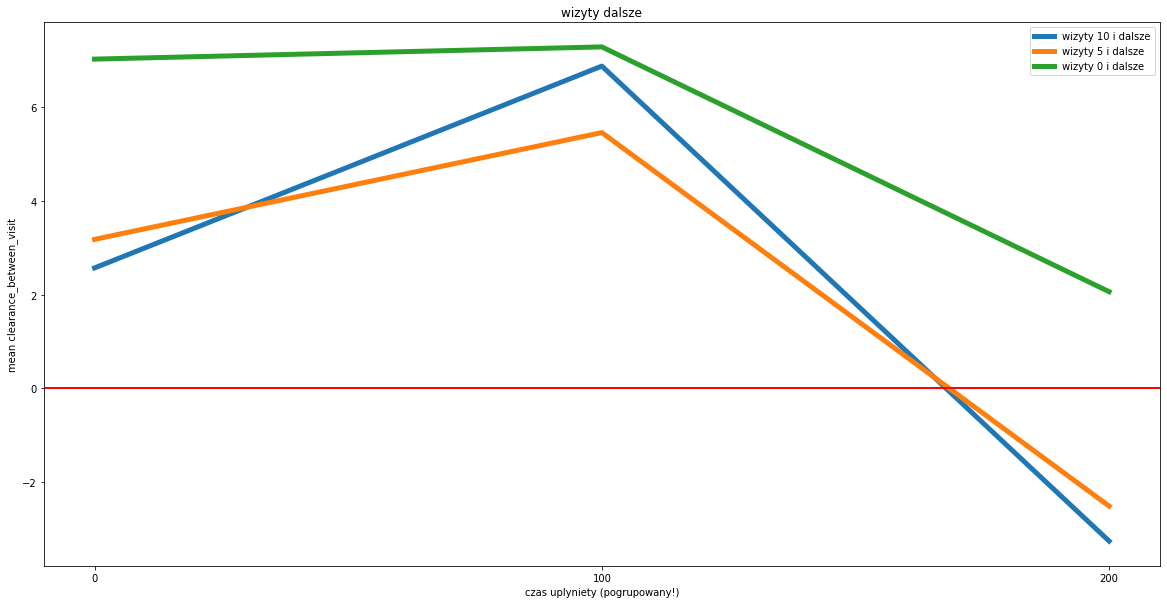

In [6]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,100,200], increment = 100)

/Users/szczekulskij/side_projects/paper_publication/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_group'] = labeled_group


,time_group,patients_in_bucket wizyty 10 i dalsze,patients_in_bucket wizyty 5 i dalsze,patients_in_bucket wizyty 0 i dalsze
0,0,59,149,268
1,200,14,42,56
2,400,1,3,10


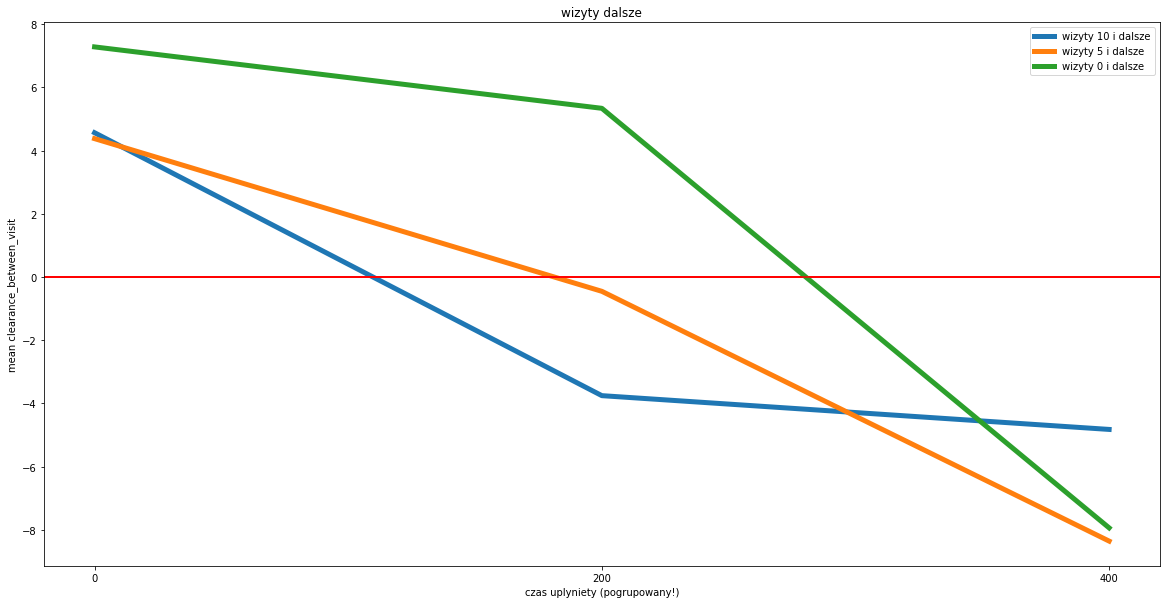

In [7]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,200,400], increment = 200)

In [8]:
# graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,100,200,300], increment = 100) # I dont like this one

/Users/szczekulskij/side_projects/paper_publication/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_group'] = labeled_group


,time_group,patients_in_bucket wizyty 10 i dalsze,patients_in_bucket wizyty 5 i dalsze,patients_in_bucket wizyty 0 i dalsze
0,0,47,112,207
1,120,17,57,93
2,240,9,22,24
3,360,1,3,10


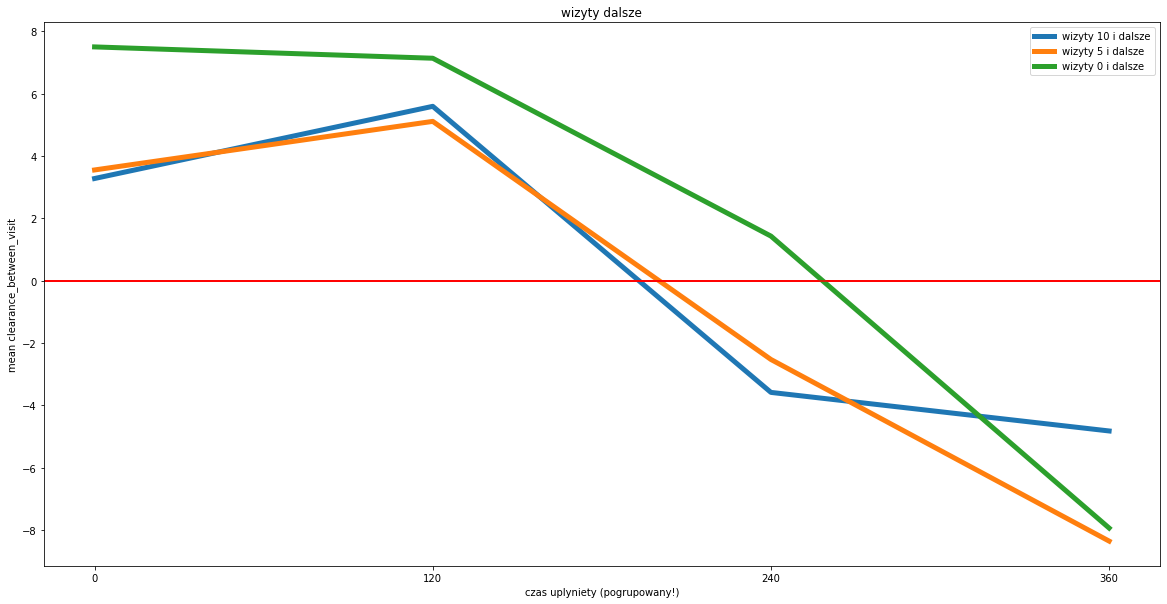

In [9]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,120,240,360], increment = 120)

/Users/szczekulskij/side_projects/paper_publication/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_group'] = labeled_group


,time_group,patients_in_bucket wizyty 10 i dalsze,patients_in_bucket wizyty 5 i dalsze,patients_in_bucket wizyty 0 i dalsze
0,0,38,85,150
1,90,24,75,136
2,180,9,21,27
3,270,2,10,11
4,360,1,3,10


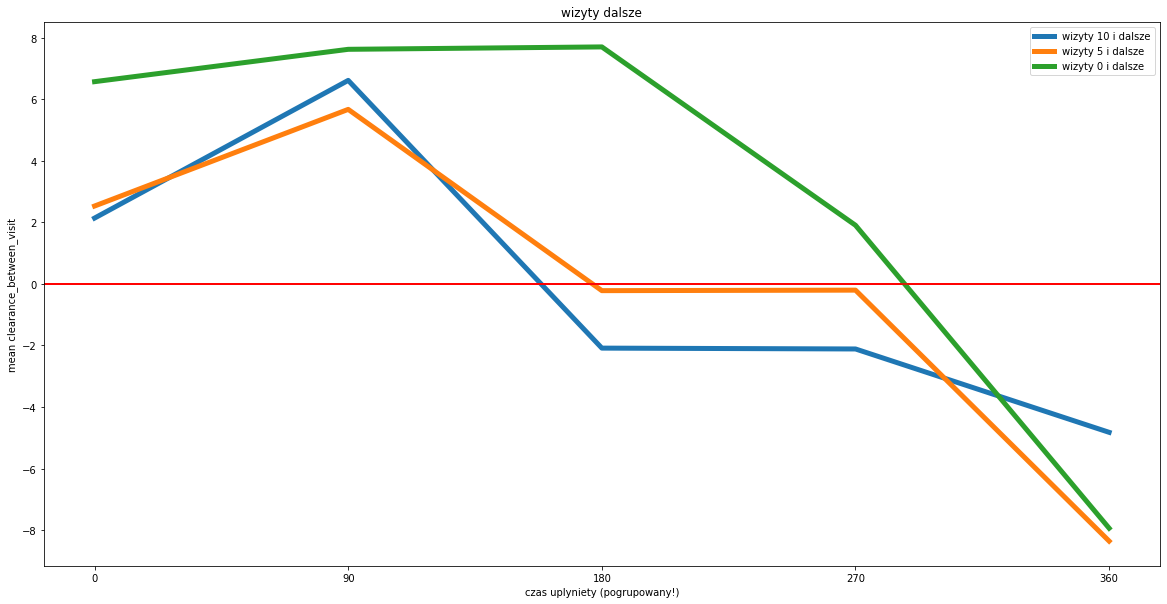

In [10]:
graph_multiple_time_group_based_avg_graph(non_moved_df,blizsze = False, GROUPS = [0,90,180,270,360], increment=90)

### All users plots:

In [11]:
# plot_all_users(non_moved_df, title = 'data bez zmian')
# plot_all_users(moved_df, title = 'data moved to 0s')
# plot_all_users(non0s_df, title = 'data bez 0s')

In [73]:
x = np.array([0,1,2,3,4])
m = 0.5
m*x

array([0. , 0.5, 1. , 1.5, 2. ])

In [103]:
def scatter_plot(df, label = '', label2 = ''):
    x = df['time']
    y = df['clearance_between_visit']
    m, b = np.polyfit(x, y, 1)
    x = [min(365,i) for i in x]
    plt.scatter(x,y, label = label)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('time passed (days)')
    plt.ylabel('clearance between visits')
    x = np.array(x)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, '--', linewidth = 1, linestyle = '--', label = label2)

# Exploratory area:

If time was longer than 360 I changed it to 360 to keep graph readable


/Users/szczekulskij/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  if sys.path[0] == '':
/Users/szczekulskij/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  if sys.path[0] == '':
/Users/szczekulskij/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  if sys.path[0] == '':
/Users/szczekulskij/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: linestyle is redundan

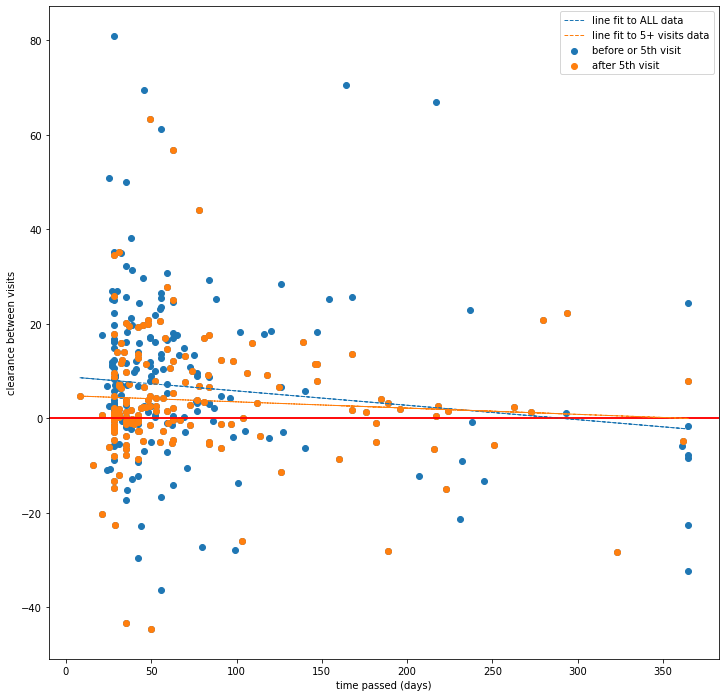

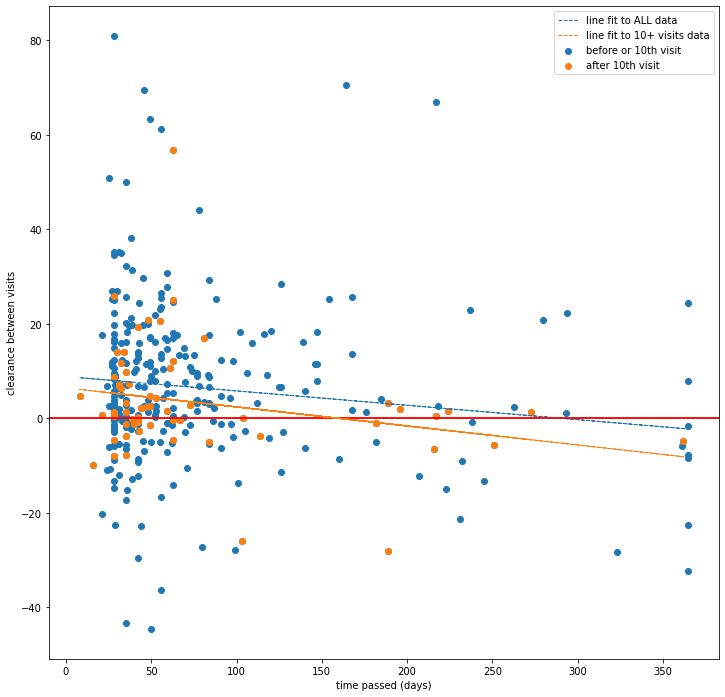

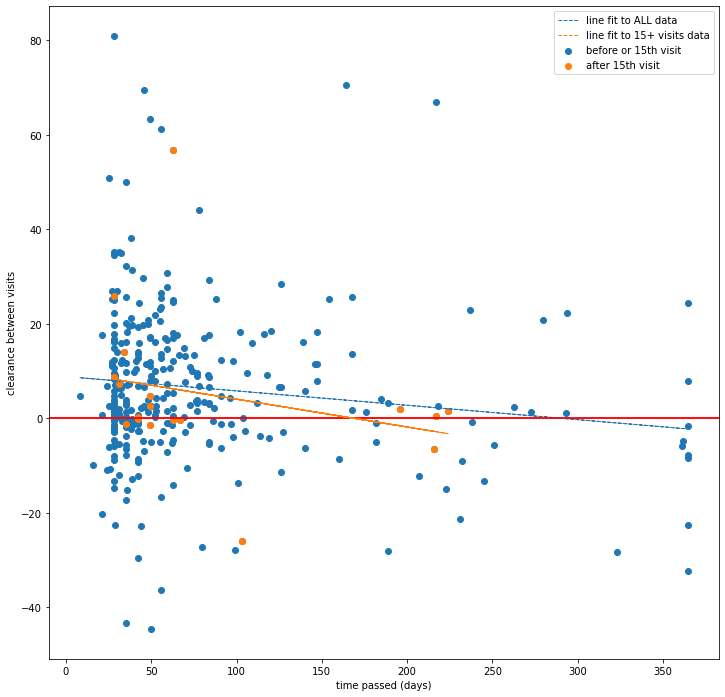

In [107]:
print('If time was longer than 360 I changed it to 360 to keep graph readable')

plt.figure(figsize=(12,12))
scatter_plot(non_moved_df, label = 'before or 5th visit', label2 ='line fit to ALL data')
scatter_plot(non_moved_df.loc[non_moved_df['visit_number'] > 5], label = 'after 5th visit', label2= 'line fit to 5+ visits data')
plt.legend()

plt.figure(figsize=(12,12))
scatter_plot(non_moved_df, label = 'before or 10th visit', label2 ='line fit to ALL data')
scatter_plot(non_moved_df.loc[non_moved_df['visit_number'] > 10], label = 'after 10th visit', label2= 'line fit to 10+ visits data')
plt.legend()

plt.figure(figsize=(12,12))
scatter_plot(non_moved_df, label = 'before or 15th visit', label2 ='line fit to ALL data')
scatter_plot(non_moved_df.loc[non_moved_df['visit_number'] > 15], label = 'after 15th visit', label2= 'line fit to 15+ visits data')
plt.legend()